In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import scipy
from matplotlib import gridspec
from tensorflow.keras.layers import Layer
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, Dense, Input, Layer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import scipy
from matplotlib import gridspec
from tensorflow.keras.layers import Layer

ModuleNotFoundError: No module named 'tensorflow'

In [9]:
class MyLayer(Layer):

    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._r = self.add_weight(name='x', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.RandomUniform(minval= 0.1, maxval=5.), #'uniform',
                                    trainable=True)
        self._u = self.add_weight(name='x', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.RandomUniform(minval=-5, maxval=5.), #'uniform',
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, X):
        t = np.pi
        npc = [[self._r*np.cos(t) + self._u*np.sin(t)/self._r, self._u*np.cos(t)/self._r - self._r*np.sin(t)],[np.sin(t)/self._r, np.cos(t)/self._r]]
        M = tf.convert_to_tensor(npc)
        M = tf.reshape(M, [2, 2])
        #print("SHAPE OF THINGS:", tf.shape(self._c), "*****", tf.shape(self._s), "*****", tf.shape(M), "****", tf.shape(X) )
        #print("M:", M)
        return tf.linalg.matmul(X, M)

In [12]:
#Quick vanilla GAN from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', input_dim=n_inputs))
	model.add(Dense(25, activation='relu', input_dim=n_inputs))    
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(n_outputs=1):
	#model = Sequential()
	#model.add(Dense(15, activation='relu', input_dim=n_outputs))
	#model.add(Dense(15, activation='relu', input_dim=n_outputs))    
	#model.add(Dense(n_outputs, activation='linear'))

	mymodel_inputtest = Input(shape=(2,))
	mymodel_test = MyLayer()(mymodel_inputtest)
	model = Model(mymodel_inputtest, mymodel_test)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
# generate n real samples with class labels
def generate_real_samples(n):
	X = np.random.multivariate_normal([0, 0], [[1, 0],[0, 1]],n)
	y = ones((n, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(n):
	# generate points in the latent space
	x_input = generate_real_samples(n)
	return x_input[0]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, n):
	# generate points in latent space
	x_input = generate_latent_points(n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

def generate_fake_samples_with_input(generator, n):
	# generate points in latent space
	x_input = generate_latent_points(n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y, x_input
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		if (i+1) % n_eval == 0:
			print("epoch = ", i)

In [ ]:
N = 2
r_i = []
u_i = []
r_f = []
u_f = []
for j in range(N):
    print("j = ", j)
    # create the discriminator
    discriminator = define_discriminator()
    # create the generator
    generator = define_generator()
    # create the gan
    gan_model = define_gan(generator, discriminator)
    r_i.append(generator.layers[-1].get_weights()[0][0])
    u_i.append(generator.layers[-1].get_weights()[1][0])
    # train model
    train(generator, discriminator, gan_model)
    r_f.append(generator.layers[-1].get_weights()[0][0])
    u_f.append(generator.layers[-1].get_weights()[1][0])
print("r_i = ", r_i)
print("u_i = ", u_i)
print("r_f = ", r_f)
print("u_f = ", u_f)

j =  0
epoch =  1999
epoch =  3999
epoch =  5999
epoch =  7999
epoch =  9999
j =  1


In [1]:
r_i =  [4.047737, 0.84063965, 0.13682911, 3.8362315, 3.8677125, 3.6373777, 2.8207164, 2.4288027, 3.2546165, 1.873911, 4.6465254, 3.0711076, 1.3932312, 2.7272558, 3.3701437, 4.035857, 4.7524476, 4.4768085, 3.0448525, 4.9576974]
u_i =  [3.3579054, -4.5666494, -0.15011692, -3.540461, 1.6594086, 0.740963, -3.8030112, 4.389099, -2.4899662, 2.7390156, -0.43959713, -2.5205946, 0.37490845, -2.0045698, -2.9170394, 0.34424686, 2.1927428, 4.366885, -3.0970168, -4.181629]
r_f =  [1.0068989, 0.9758745, 0.984598, 1.00167, 0.9945651, 0.94825447, 1.0486709, 1.0948684, 1.0296663, 0.99369985, 0.9932631, 1.0295595, 1.0492258, 1.0054741, 0.9595521, 1.015585, 0.9778937, 1.0091602, 0.93136644, 0.9979317]
u_f =  [-0.0561115, -0.0025799843, 0.048850406, -0.067383595, 0.07411632, 0.05210436, 0.008509087, -0.0027763678, -0.05630437, 0.022677545, 0.0114689255, -0.00998354, 0.06967805, 0.049570683, -0.0018069658, 0.014975463, -0.019112213, 0.034702126, -0.017755948, 0.001407847]

In [2]:
import  matplotlib.pyplot as plt

Text(0, 0.5, 'u_f')

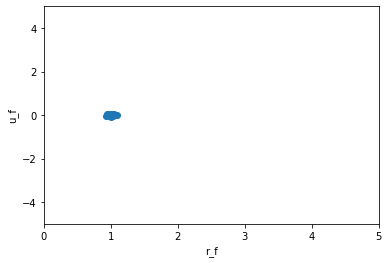

In [4]:
plt.scatter(r_f, u_f)
plt.xlim(0, 5)
plt.ylim(-5, 5)
plt.xlabel("r_f")
plt.ylabel("u_f")

Text(0, 0.5, 'r_f')

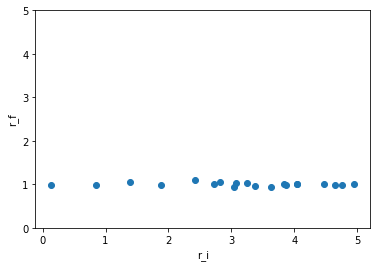

In [13]:
plt.scatter(r_i, r_f)
plt.ylim(0, 5)
plt.xlabel("r_i")
plt.ylabel("r_f")

Text(0, 0.5, 'u_f')

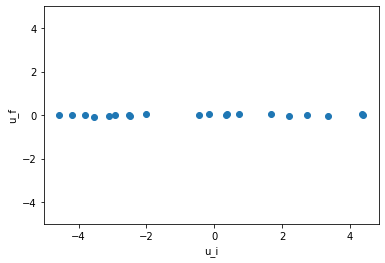

In [15]:
plt.scatter(u_i, u_f)
plt.ylim(-5, 5)
plt.xlabel("u_i")
plt.ylabel("u_f")